In [195]:
%load_ext autoreload
%autoreload 2
from datasets import load_dataset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from scipy.sparse import hstack
import nltk as nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import numpy as np
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from IPython.display import clear_output
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adnan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adnan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\adnan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [196]:
# Loading files
train_files = [
    'data/FiQA_ABSA_task1/task1_headline_ABSA_train.json',
    'data/FiQA_ABSA_task1/task1_post_ABSA_train.json'
]

In [197]:
## Loading data from JSON
import json

def load_fiqa_sa_from_json(json_files):
    train_text = []
    train_labels = []

    for file in json_files:
        with open(file, 'r', encoding='UTF-8') as handle:
            dataf = json.load(handle)
        dataf_text = [dataf[k]["sentence"] for k in dataf.keys()]
        train_text.extend(dataf_text)
        dataf_labels = [float(dataf[k]["info"][0]["sentiment_score"]) for k in dataf.keys()]
        train_labels.extend(dataf_labels)
    train_text = np.array(train_text)
    train_labels = np.array(train_labels)
    return train_text, train_labels


def threshold_scores(scores):
    """
    Convert sentiment scores to discrete labels.
    0 = negative.
    1 = neutral.
    2 = positive.
    """
    labels = []
    for score in scores:
        if score < -0.2:
            labels.append(0)
        elif score > 0.2:
            labels.append(2)
        else:
            labels.append(1)
            
    return np.array(labels)


all_text, all_labels = load_fiqa_sa_from_json(train_files)
    
print(f'Number of instances: {len(all_text)}')
print(f'Number of labels: {len(all_labels)}')

all_labels = threshold_scores(all_labels)
print(f'Number of negative labels: {np.sum(all_labels==0)}')
print(f'Number of neutral labels: {np.sum(all_labels==1)}')
print(f'Number of positive labels: {np.sum(all_labels==2)}')

Number of instances: 1111
Number of labels: 1111
Number of negative labels: 310
Number of neutral labels: 195
Number of positive labels: 606


In [198]:
# Split the data into training, validation, testing sets.

from sklearn.model_selection import train_test_split

# Split test data from training data
train_tweets, test_tweets, train_labels, test_labels = train_test_split(
    all_text, 
    all_labels, 
    test_size=0.2, 
    stratify=all_labels  # make sure the same proportion of labels is in the test set and training set
)

# Split validation data from training data
train_tweets, val_documents, train_labels, val_labels = train_test_split(
    train_tweets, 
    train_labels, 
    test_size=0.2, 
    stratify=train_labels  # make sure the same proportion of labels is in the test set and training set
)

print(f'Number of training instances = {len(train_tweets)}')
print(f'Number of validation instances = {len(val_documents)}')
print(f'Number of test instances = {len(test_tweets)}')


Number of training instances = 710
Number of validation instances = 178
Number of test instances = 223


In [199]:
# Print example tweet
print(f'What does one instance look like from the training set? \n\n{train_tweets[234]}')
print(f'...and here is its corresponding label \n\n{train_labels[234]}')

What does one instance look like from the training set? 

Is Trouble Brewing At Legal & General Group Plc And Aviva plc?
...and here is its corresponding label 

0


# 1. Preprocessing using  lemmatization
We create a lemmatizer tokenizer that reduces words to their root forms. This reduces the vocabulary size.

In [200]:
# We create a lemmaTokenizer class that applies lemmatization when tokenizing.
class LemmaTokenizer(object):
    
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        
    def __call__(self, tweets):
        return [self.wnl.lemmatize(self.wnl.lemmatize(self.wnl.lemmatize(tok, pos='n'), pos='v'), pos='a') for tok in word_tokenize(tweets)]
    

# 2.1 Using bi-grams + unigrams as feature
We apply our tokenizer and set it to allow ngram features (both unigrams and bigrams). 

In [201]:
vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(), ngram_range=(1,2))
vectorizer.fit(train_tweets)
X_train = vectorizer.transform(train_tweets)
X_val = vectorizer.transform(val_documents)
X_test_tweets = vectorizer.transform(test_tweets)
# Let's look at some of the features.
print(list(vectorizer.vocabulary_)[:10])

C:\Users\adnan\anaconda3\envs\data_analytics\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['$', 'spy', 'could', 'the', 'pride', 'of', 'social', 'medium', 'be', 'gettin']


In [202]:
# Checking full vocabulary size:
print(f' Full vocabulary size: {len(vectorizer.vocabulary_)}')
vocabulary = vectorizer.vocabulary_

 Full vocabulary size: 10613


              precision    recall  f1-score   support

           0       0.61      0.46      0.52        50
           1       0.67      0.19      0.30        31
           2       0.66      0.90      0.76        97

    accuracy                           0.65       178
   macro avg       0.65      0.52      0.53       178
weighted avg       0.65      0.65      0.61       178



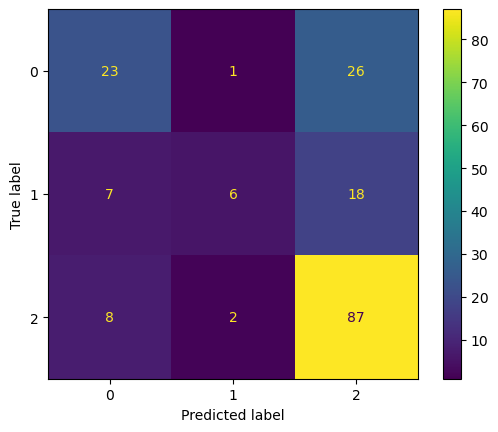

In [203]:
# Now let's fit our data to the model.
classifier = LogisticRegression()
classifier.fit(X_train, train_labels)
y_val_pred = classifier.predict(X_val)
cm = confusion_matrix(val_labels, y_val_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
print(classification_report(val_labels, y_val_pred))

In [204]:
# Using POS-NEG lexicon features

In [205]:
# instantiate analyzer
analyser = SentimentIntensityAnalyzer()
# fetch vocabulary
vocabulary = vectorizer.vocabulary_
# create empy holders for lexicon scores.
lexicon_pos_scores = np.zeros((1, len(vocabulary)))
lexicon_neg_scores = np.zeros((1, len(vocabulary)))

for i, term in enumerate(vocabulary):
    if term in analyser.lexicon and analyser.lexicon[term] > 0:
        lexicon_pos_scores[0, i] = 1
    elif term in analyser.lexicon and analyser.lexicon[term] < 0:
        lexicon_neg_scores[0, i] = 1

In [206]:
# This enables us to get the total positive and total negative counts for each set:
lexicon_pos_train = np.sum(X_train.multiply(lexicon_pos_scores), axis=1)
lexicon_pos_val = np.sum(X_val.multiply(lexicon_pos_scores), axis=1)
lexicon_pos_test = np.sum(X_test_tweets.multiply(lexicon_pos_scores), axis=1)

lexicon_neg_train = np.sum(X_train.multiply(lexicon_neg_scores), axis=1)
lexicon_neg_val = np.sum(X_val.multiply(lexicon_neg_scores), axis=1)
lexicon_neg_test = np.sum(X_test_tweets.multiply(lexicon_neg_scores), axis=1)

In [207]:
X_train = hstack((X_train, lexicon_pos_train, lexicon_neg_train))
X_val = hstack((X_val, lexicon_pos_val, lexicon_neg_val))
X_test_tweets = hstack((X_test_tweets, lexicon_pos_test, lexicon_neg_test))

              precision    recall  f1-score   support

           0       0.61      0.46      0.52        50
           1       0.67      0.19      0.30        31
           2       0.66      0.90      0.76        97

    accuracy                           0.65       178
   macro avg       0.65      0.52      0.53       178
weighted avg       0.65      0.65      0.61       178



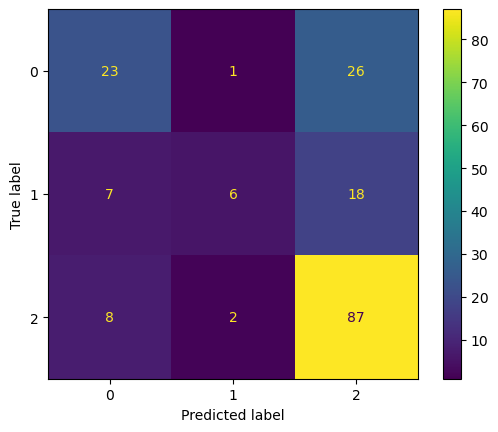

In [208]:
classifier = LogisticRegression()
classifier.fit(X_train, train_labels)
y_val_pred = classifier.predict(X_val)
# Checking performance
cm = confusion_matrix(val_labels, y_val_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
print(classification_report(val_labels, y_val_pred))

In [209]:
# Key part is investigating the errors by looking at the actual values, so let's do that:
error_indexes = y_val_pred != val_labels  # let's compare predictions to true values for labels

# get the tweets where the classifier made an error:
tweets_err = np.array(val_documents)[error_indexes]

pred_err = y_val_pred[error_indexes]
true_err = np.array(val_labels)[error_indexes]

for i in range(10):
    print(f'Tweet: {tweets_err[i]}; true label = {true_err[i]}, prediction = {pred_err[i]}.')

Tweet: $AAPL wants lower. up waves getting smaller on the 2 min; true label = 0, prediction = 2.
Tweet: LSE-Deutsche Boerse merger would signal end to exchange mega-deals; true label = 1, prediction = 0.
Tweet: Tesco share price closes higher as two more directors leave grocer; true label = 2, prediction = 0.
Tweet: On #FEDDAY looking for a sharp move up in equities $AAPL $HD $LOW $FB seeing $UVXY $TVIX getting hammered, even though market is down.; true label = 2, prediction = 0.
Tweet: Sold out $TZA 45 $PUT (down $1), which were hedging my 45 $CALL. Letting the calls ride solo now.; true label = 2, prediction = 0.
Tweet: $tsla X recall not a big deal... the problem is now they will have an excuse to guide way way lower...; true label = 1, prediction = 0.
Tweet: $ATVI ooks pretty bullish for now. from a short-term perspective, it's got a good chance of maybe sliding back to 33.70 #stocks #investing; true label = 2, prediction = 0.
Tweet: GlaxoSmithKline set to complete $20 billion Nov

# Performance on test set

              precision    recall  f1-score   support

           0       0.79      0.48      0.60        62
           1       0.62      0.33      0.43        39
           2       0.70      0.93      0.80       122

    accuracy                           0.70       223
   macro avg       0.70      0.58      0.61       223
weighted avg       0.71      0.70      0.68       223



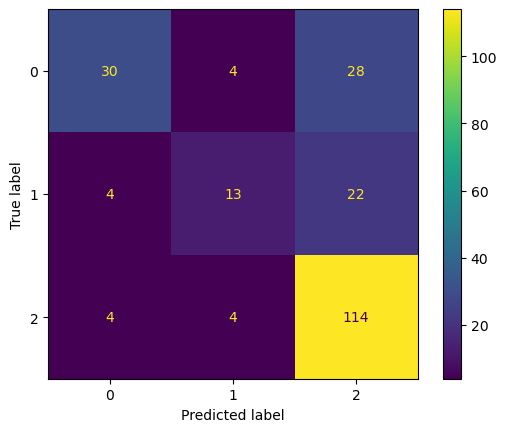

In [210]:
# Let's test the performance on the test set.
y_test_pred = classifier.predict(X_test_tweets)
# Checking performance
cm = confusion_matrix(test_labels, y_test_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
print(classification_report(test_labels, y_test_pred))

# 4. Extracting topics using LDA

In [211]:
# First let's get another clean split of the data. 
from sklearn.model_selection import train_test_split

# Split test data from training data
train_tweets, test_tweets, train_labels, test_labels = train_test_split(
    all_text, 
    all_labels, 
    test_size=0.2, 
    stratify=all_labels  # make sure the same proportion of labels is in the test set and training set
)

# Split validation data from training data
train_tweets, val_tweets, train_labels, val_labels = train_test_split(
    train_tweets, 
    train_labels, 
    test_size=0.2, 
    stratify=train_labels  # make sure the same proportion of labels is in the test set and training set
)

print(f'Number of training instances = {len(train_tweets)}')
print(f'Number of validation instances = {len(val_tweets)}')
print(f'Number of test instances = {len(test_tweets)}')


Number of training instances = 710
Number of validation instances = 178
Number of test instances = 223


In [212]:
 # We use the function below for tokenization. Does a number of things, including removing small words, deleting words with special chars,  changing uppercase to lowercase, and more.
def preprocess(text):
    final_results=[]
    for token in simple_preprocess(text) : 
        if token not in STOPWORDS:
            final_results.append(WordNetLemmatizer().lemmatize(token, 'v'))
    return final_results

# Create a list of preprocessed documents
processed = []
for doc in train_tweets:
    processed.append(preprocess(doc))
print(processed)

[['spy', 'bull', 'end', 'wait', 'setup'], ['mtd', 'mettler', 'toledo', 'ready', 'breakout'], ['tesla', 'recall', 'model', 'cars', 'https', 'bkvstl', 'tsla'], ['hotels', 'deny', 'report', 'starwood', 'merger', 'talk'], ['tsla', 'recall'], ['nflx', 'low'], ['turnaround', 'buy', 'bhp', 'billiton', 'plc', 'home', 'retail', 'group', 'plc'], ['peroni', 'grolsch', 'sale', 'ab', 'inbev', 'plan', 'acquisition', 'sabmiller'], ['tesco', 'abandon', 'video', 'stream', 'ambition', 'blinkbox', 'sale'], ['update', 'barclays', 'expect', 'gain', 'settle', 'lehman', 'bros', 'trustee'], ['ouch', 'look', 'like', 'tsla', 'short', 'get', 'skin'], ['itv', 'share', 'price', 'jump', 'report', 'comcast', 'nbcuniversal', 'bid', 'takeover'], ['fb', 'turn', 'early', 'trade', 'https', 'reuf', 'pzhbm'], ['cost', 'costco', 'stellar', 'day', 'hold', 'day', 'move', 'average'], ['wpp', 'world', 'largest', 'ad', 'agency', 'report', 'strong', 'growth'], ['london', 'stock', 'exchange', 'deutsche', 'boerse', 'merger', 'threa

In [213]:
from gensim.corpora import Dictionary
# create a dictionary of word<->id key/val pairs.
dictionary = Dictionary(processed) 
print(dictionary)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed]

Dictionary(2280 unique tokens: ['bull', 'end', 'setup', 'spy', 'wait']...)


In [214]:
# Getting means of thetas

from gensim.matutils import any2sparse
from gensim.models import LdaModel

lda_model =  LdaModel(bow_corpus, 
                      num_topics=10, 
                      id2word=dictionary,                                    
                      passes=10,
                    ) 

def get_tweet_topic_dists(train_tweets, lda_model):
    thetas = []
    for i in range(len(train_tweets)):
        # Get the tweet
        unseen_tweet = train_tweets[i]

        # Preprocess for bag of words:
        bow_vector = dictionary.doc2bow(preprocess(unseen_tweet))

        # Let's get the topic distribution:
        theta_tweet = lda_model[bow_vector]

        thetas.append(theta_tweet)

    return thetas

thetas = get_tweet_topic_dists(train_tweets, lda_model)

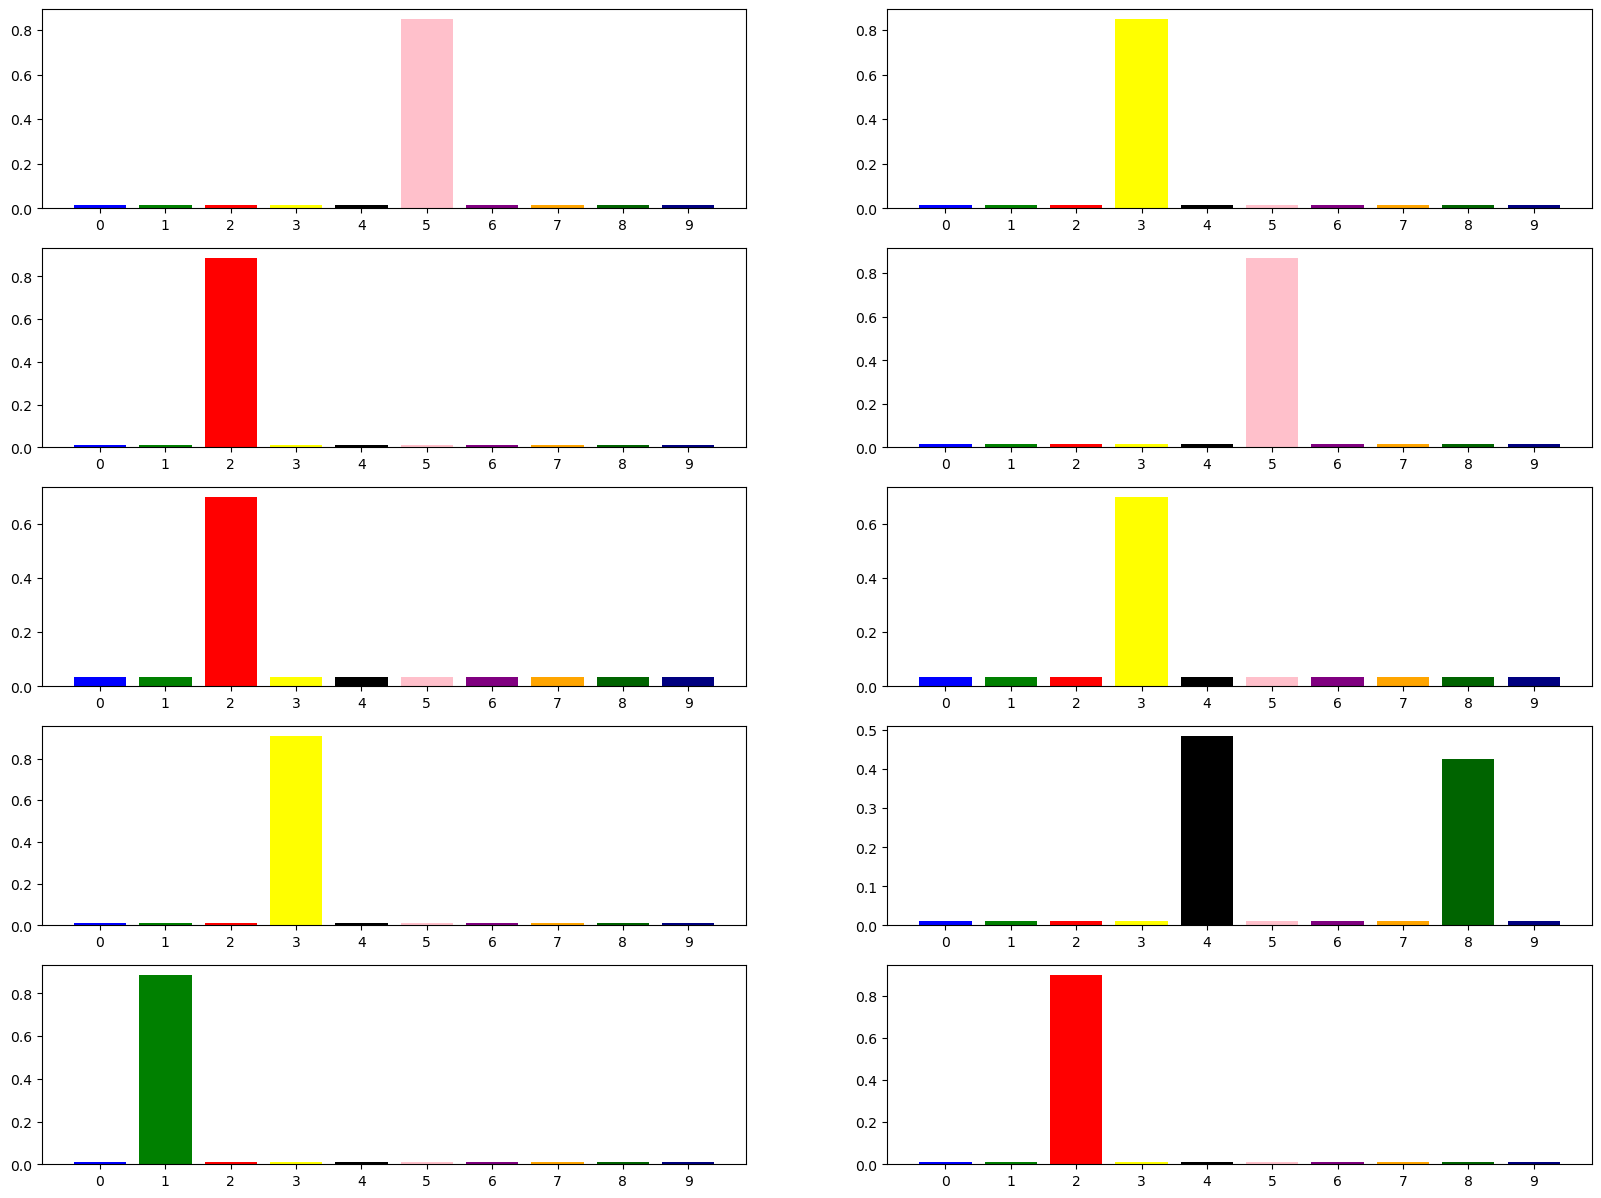

In [215]:

# We will use colours to represent topics.
colours = ['blue', 'green', 'red', 'yellow', 'black', 'pink', 'purple',
           'orange',  'darkgreen',  'navy', 'crimson']

def convert_theta_sparse_to_dense_vector(theta_dist_sparse, num_topics):
    theta_dist = np.zeros(num_topics)  # an empty array
    
    # get active topics
    active_topics_for_dist, probs = map(list, zip(*theta_dist_sparse))
    
    # add to thetas_dist
    for i, topic in enumerate(active_topics_for_dist):
        if topic >= num_topics:
            break
            
        theta_dist[topic] = probs[i]
    
    return theta_dist

# Create barchart
def plot_theta(thetas, i, num_tweets, num_topics):
    plt.subplot(int((num_tweets+1)/2), 2, i+1)
    theta_dist = convert_theta_sparse_to_dense_vector(thetas[i], num_topics)
    plt.bar(x=np.arange(len(theta_dist)), height=theta_dist, color=colours, tick_label=np.arange(num_topics))

plt.figure(figsize=(20,15))

num_tweets = 10
num_topics = 10
counter = 0
for i, theta in enumerate(thetas):
    if (counter < 10):
        plot_theta(thetas, i, num_tweets, num_topics)
        counter +=1
plt.show()

In [216]:
# Merge arrays for later 
arr = train_tweets
arr_2 = train_labels

arrays = [arr,arr_2]
new_arr = np.stack(arrays, axis=1)
print(new_arr[new_arr[:,1] =='1'])

[['InterContinental Hotels Denies Reports of Starwood Merger Talks' '1']
 ['Tesco Abandons Video-Streaming Ambitions in Blinkbox Sale' '1']
 ['UPDATE: Barclays Expects Gain After Settling With Lehman Bros Trustee'
  '1']
 ['$COST Costco less than stellar day but it held the 50 day moving average'
  '1']
 ["Are ARM Holdings plc, Domino's Pizza Group plc and ASOS plc 3 must-have growth stocks?"
  '1']
 ['UPDATE 1-BP shareholders back more disclosure on climate change risks'
  '1']
 ['Analyst Views: Astrazeneca shares have seen recent volatility; what will 2015 ...'
  '1']
 ['$AAPL at pivot area on intraday chart- break here could send this to 50-day SMA, 457.80 http://stks.co/jPbN'
  '1']
 ['Royal Mail gets mixed bag from Ofcom postal regulation report' '1']
 ['Sold some $TSLA Puts this morning Closed them at the close. Helps pay for monthly expenses'
  '1']
 ['$AAPL Taking out the shorts here, a punishing reminder not to spear the  strongest in the herd.'
  '1']
 ['GlaxoSmithKline start

In [217]:
# Show numbers till 8 decimal points for testing.
np.set_printoptions(precision=8)
def get_tweet_mean_topics():
    # Create a matrix where each row corresponds to a label
    mean_thetas = np.zeros((len(['0','1','2']), 10))
    label_arr = ['0','1','2']
    for label in label_arr:
        # call get_tweet_topic_dists
        thetas_t_sparse = get_tweet_topic_dists(train_tweets[new_arr[:,1] ==label], lda_model)
        # convert to a dense vector
        thetas_t = []
        for theta_dist_t_sparse in thetas_t_sparse:
            if not theta_dist_t_sparse:
                continue
            thetas_dist = convert_theta_sparse_to_dense(theta_dist_t_sparse, 10)
            thetas_t.append(thetas_dist)
        # Get the mean theta
        mean_theta_t = np.mean(thetas_t, axis=0)
        mean_thetas[int(label)] = mean_theta_t
        print(mean_thetas[int(label)])
    return mean_thetas
   
mean_arr = get_tweet_mean_topics()

print(mean_arr.shape)

[0.09219697 0.0788403  0.12820861 0.17429895 0.07726272 0.14904871
 0.08413242 0.06406015 0.06814638 0.06710595]
[0.12214568 0.04532252 0.09469481 0.08797631 0.11779371 0.15613929
 0.08191592 0.09639918 0.11815154 0.06200185]
[0.08134679 0.11278748 0.08489174 0.12479372 0.08312044 0.13293255
 0.08752144 0.10812178 0.08240337 0.08314326]
(3, 10)


[0.09219675 0.07884064 0.12820702 0.17424844 0.07731332 0.14904856
 0.08413336 0.06405564 0.06814703 0.06711043]
[0.12214495 0.04532253 0.09469481 0.08797598 0.11779541 0.15613714
 0.08191653 0.09639922 0.11815258 0.06200167]
[0.0813468  0.1127879  0.08489233 0.12479264 0.08312029 0.13294053
 0.08751496 0.10812168 0.08240306 0.08314238]


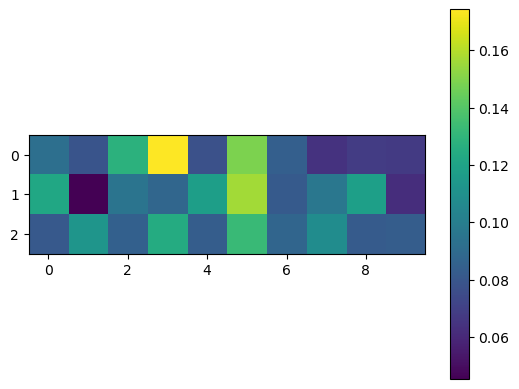

In [218]:
def plot_tweet_topic_matrix():
    # Get mean tweet topics dists
    mean_thetas = get_tweet_mean_topics()
    # Let's show a heatmap to see which topics occur the most for different labels
    plt.imshow(mean_thetas)
    plt.colorbar()
    plt.show()
plot_tweet_topic_matrix()

In [223]:
# For each topic, let's show the words occuring in that topic, so we can identify it.

for idx, topic in lda_model.print_topics(-1):
    print("Topic ID: {} \nAssociated Words:\n {}".format(idx, topic ))
    print("\n")

Topic ID: 0 
Associated Words:
 0.019*"http" + 0.018*"stks" + 0.009*"share" + 0.008*"rise" + 0.007*"support" + 0.007*"break" + 0.007*"low" + 0.006*"aapl" + 0.006*"charter" + 0.006*"look"


Topic ID: 1 
Associated Words:
 0.018*"long" + 0.013*"http" + 0.011*"stks" + 0.010*"go" + 0.009*"dividend" + 0.007*"buy" + 0.007*"sell" + 0.006*"short" + 0.006*"fb" + 0.006*"share"


Topic ID: 2 
Associated Words:
 0.029*"tsla" + 0.020*"recall" + 0.019*"https" + 0.017*"model" + 0.013*"tesla" + 0.008*"http" + 0.007*"suvs" + 0.007*"seat" + 0.007*"short" + 0.006*"stks"


Topic ID: 3 
Associated Words:
 0.018*"https" + 0.017*"short" + 0.014*"sell" + 0.011*"fb" + 0.010*"stks" + 0.010*"http" + 0.010*"time" + 0.009*"aapl" + 0.009*"new" + 0.009*"get"


Topic ID: 4 
Associated Words:
 0.019*"plc" + 0.013*"inbev" + 0.012*"https" + 0.011*"sabmiller" + 0.010*"ab" + 0.009*"berkshire" + 0.008*"buy" + 0.008*"hold" + 0.007*"short" + 0.007*"billion"


Topic ID: 5 
Associated Words:
 0.033*"http" + 0.031*"stks" + 0.01